# CLV non-contractual settings in continuous time
Based on:<br>
[Probability Models for Customer-Base Analysis](https://brucehardie.com/talks/ho_cba_tut_art_09.pdf)<br>
[Implementing the Pareto/NBD Model for Customer-Base Analysis](http://brucehardie.com/notes/008/pareto_nbd_MATLAB.pdf)

Hypothetical non-contractual setting:<br>
- New customers at CDNOW, 1/97–3/97
- Systematic sample (1/10) drawn from panel of 23,570 new customers
- 39-week calibration period
- 39-week forecasting (holdout) period
- Initial focus on transactions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gamma as gamma_fn
from scipy.special import hyp2f1
from scipy.stats import gamma as gamma_dist

In [2]:
customers = pd.read_excel('cdnow_data.xls')
customers.head()

,ID,p1x,t_x,T,p2x
0,1,2,30.428571,38.857143,1
1,2,1,1.714286,38.857143,0
2,3,0,0.000000,38.857143,0
3,4,0,0.000000,38.857143,0
4,5,0,0.000000,38.857143,0


In [3]:
sales = pd.read_excel('cdnow_data.xls', sheet_name='Cum. Repeat Sales')
sales.head()

,1,0
0,2,19
1,3,42
2,4,81
3,5,119
4,6,192


In [4]:
def pareto_NBD_likelihood(x, data, sign = 1):
    """Pareto/NBD likelihood
    
    Computes log likelihood of Pareto/NBD model of customer 
    behaviour in continuous-time non-contractual settings.
    
    :param x: (r, alpha, s, beta)
    :param data: customer dataframe
    :param sigh: multiplier of the result (scipy has no 'maximize' fn)
    
    :returns: log likelihood
    """
    r = x[0]
    alpha = x[1]
    s = x[2]
    beta = x[3]
    
    log_likelihood = 0
    
    for i in range(data.shape[0]):
        row = data.iloc[i]
        if alpha >= beta:
            A0 = hyp2f1(r+s+row['p1x'], s+1,r+s+row['p1x']+1, (alpha-beta)/(alpha+row['t_x']))\
                  / ((alpha+row['t_x'])**(r+s+row['p1x']))
            A0 -= hyp2f1(r+s+row['p1x'], s+1,r+s+row['p1x']+1, (alpha-beta)/(alpha+row['T']))\
                   / ((alpha+row['T'])**(r+s+row['p1x']))
        else:
            A0 = hyp2f1(r+s+row['p1x'], r+row['p1x'],r+s+row['p1x']+1, (beta-alpha)/(beta+row['t_x']))\
                  / ((beta+row['t_x'])**(r+s+row['p1x']))
            A0 -= hyp2f1(r+s+row['p1x'], r+row['p1x'],r+s+row['p1x']+1, (beta-alpha)/(beta+row['T']))\
                   / ((beta+row['T'])**(r+s+row['p1x']))
            
        l = (gamma_fn(r+row['p1x'])*(alpha**r)*(beta**s)) / gamma_fn(r)
        l *= 1 / (((alpha+row['T'])**(r+row['p1x'])) * ((beta+row['T'])**s)) \
                 + (s / (r+s+row['p1x'])) * A0
        
        log_likelihood += np.log(l)
        
    return log_likelihood * sign

In [5]:
r, alpha, s, beta = minimize(pareto_NBD_likelihood, (0.5,10,0.5,10), args=(customers, -1), method='nelder-mead', options={'fatol': 0.1}).x

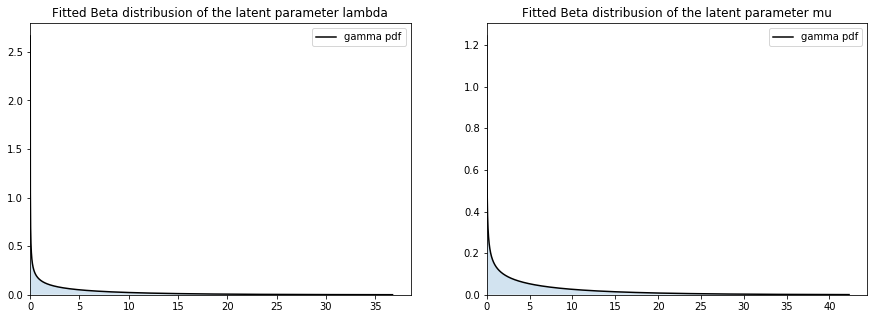

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot the distribution of lambda
x = np.linspace(gamma_dist.ppf(0.01, r, scale=alpha),gamma_dist.ppf(0.99, r, scale=alpha), 10000)
pdf_l = gamma_dist.pdf(x, r, scale=alpha)

ax1.plot(x, pdf_l, label='gamma pdf', color='k')
ax1.fill_between(x, 0, pdf_l, alpha=0.2)
ax1.set_title('Fitted Beta distribusion of the latent parameter lambda')
ax1.set_ylim(0)
ax1.set_xlim(0)
ax1.legend()

# plot the distribution of mu
x = np.linspace(gamma_dist.ppf(0.01, s, scale=beta), gamma_dist.ppf(0.99, s, scale=beta), 10000)
pdf_m = gamma_dist.pdf(x, s, scale=beta)

ax2.plot(x, pdf_m, label='gamma pdf', color='k')
ax2.fill_between(x, 0, pdf_m, alpha=0.2)
ax2.set_title('Fitted Beta distribusion of the latent parameter mu')
ax2.set_ylim(0)
ax2.set_xlim(0)
ax2.legend()

plt.show()

In [7]:
def tracking_plot(r, alpha, s, beta, data, actual):
    """Tracking plot
    
    Assess the performance of the model is to see how well it
    tracks repeat transactions over time.
    
    :param r: Pareto/NBD alpha
    :param alpha: Pareto/NBD beta
    :param s: Pareto/NBD gamma
    :param beta: Pareto/NBD delta
    :param actual: actual cumulative sales
    :param data: customer dataframe
    """
    ns = [sum(customers['T']==(273-i)/7) for i in range(1, 85)]
    ns = np.array(ns)
    
    endweek = 78
    endday = 78 * 7
    
    tmp1 = (r*beta)/(alpha*(s-1))
    tmpcumsls1 = []
    for i in range(1, endday+1):
        tmp2 = (beta/(beta+i/7))**(s-1)
        tmpcumsls1.append(tmp1*(1-tmp2))
        
    tmpcumsls2 = np.zeros((84,endday))
    for i in range(84):
        tmpcumsls2[i,i:] = tmpcumsls1[:endday-i]
        
    cumrptsls = []
    dailysls = ns.dot(tmpcumsls2)
    for i in range(endweek):
        cumrptsls.append(dailysls[i*7])
    
    cumulative = pd.DataFrame(
        index=range(2, 78),
        data={
            'actual': actual[0].values[:-1],
            'predicted': cumrptsls[2:]
        }
    )
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    cumulative.plot(ax=ax1)
    annual = cumulative.diff().fillna(cumulative)
    annual.plot(ax=ax2)
    
    ax1.set_title('Cumulative number of transactions')
    ax2.set_title('Weekly number of transactions')
    ax1.axvline(40, color='k', linestyle='--', alpha=0.5)
    ax2.axvline(40, color='k', linestyle='--', alpha=0.5)

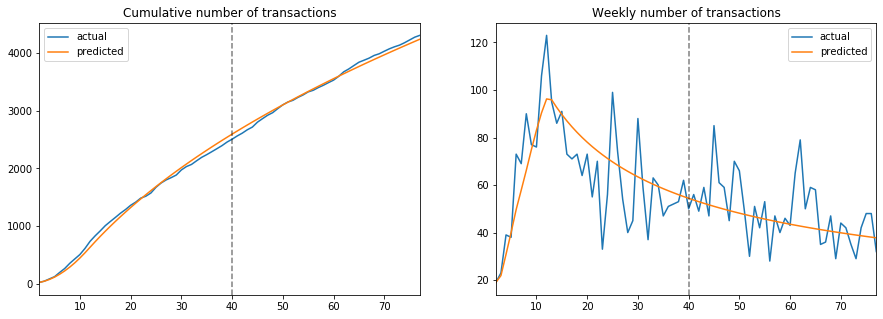

In [8]:
tracking_plot(r, alpha, s, beta, customers, sales)